<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-clean-the-data" data-toc-modified-id="Load-and-clean-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and clean the data</a></span></li><li><span><a href="#LDA-with-10-topics" data-toc-modified-id="LDA-with-10-topics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LDA with 10 topics</a></span></li><li><span><a href="#Find-the-strongest-topic-for-each-document" data-toc-modified-id="Find-the-strongest-topic-for-each-document-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Find the strongest topic for each document</a></span></li><li><span><a href="#Compute-document-similarity-using-word2vec" data-toc-modified-id="Compute-document-similarity-using-word2vec-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compute document similarity using word2vec</a></span></li><li><span><a href="#t-sne-projection,-color-coded-with-topics" data-toc-modified-id="t-sne-projection,-color-coded-with-topics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>t-sne projection, color coded with topics</a></span></li><li><span><a href="#Compute-cosine-similarity-from-doc2vec" data-toc-modified-id="Compute-cosine-similarity-from-doc2vec-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compute cosine similarity from doc2vec</a></span></li><li><span><a href="#Compare-intra-topic-similarity-vs.-inter-topic-similarity" data-toc-modified-id="Compare-intra-topic-similarity-vs.-inter-topic-similarity-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compare intra-topic similarity vs. inter-topic similarity</a></span></li><li><span><a href="#Build-word2vec-model" data-toc-modified-id="Build-word2vec-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Build word2vec model</a></span><ul class="toc-item"><li><span><a href="#Find-the-strongest-topic-for-each-term" data-toc-modified-id="Find-the-strongest-topic-for-each-term-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Find the strongest topic for each term</a></span></li></ul></li></ul></div>

In [28]:
import nlp
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from sklearn import manifold

from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from gensim.models import Word2Vec
from gensim.models import CoherenceModel

import spacy
spa = spacy.load('en')

from itertools import chain
from itertools import combinations



I want to compute document similarity based on word2vec and check if documents discussing the same topic are similar.

### Load and clean the data

In [2]:
data = nlp.load_file('../data/lee.txt')
docs = nlp.preprocess(data)
len(data), data[0], docs[0]

(300,
 'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are availabl

### LDA with 10 topics

In [3]:
lda = nlp.build_lda(docs, num_topics=10)
lda.print_topics()

[(0,
  '0.030*"afghanistan" + 0.025*"bin" + 0.025*"force" + 0.022*"laden" + 0.018*"qaeda" + 0.015*"afghan" + 0.015*"taliban" + 0.014*"united" + 0.014*"fighter" + 0.012*"state"'),
 (1,
  '0.018*"centre" + 0.016*"rate" + 0.015*"per" + 0.013*"cent" + 0.013*"police" + 0.012*"one" + 0.010*"three" + 0.010*"time" + 0.010*"bank" + 0.010*"australian"'),
 (2,
  '0.047*"fire" + 0.026*"new" + 0.018*"area" + 0.018*"sydney" + 0.017*"south" + 0.016*"company" + 0.013*"today" + 0.013*"wind" + 0.012*"also" + 0.011*"one"'),
 (3,
  '0.053*"palestinian" + 0.035*"israeli" + 0.031*"arafat" + 0.017*"attack" + 0.017*"israel" + 0.016*"hamas" + 0.014*"leader" + 0.014*"official" + 0.013*"gaza" + 0.013*"suicide"'),
 (4,
  '0.025*"worker" + 0.024*"qantas" + 0.023*"union" + 0.019*"action" + 0.018*"australian" + 0.016*"airline" + 0.014*"metre" + 0.014*"industrial" + 0.014*"company" + 0.013*"test"'),
 (5,
  '0.032*"report" + 0.031*"commission" + 0.030*"people" + 0.017*"union" + 0.016*"royal" + 0.014*"job" + 0.014*"hea

### Find the strongest topic for each document

In [4]:
def get_strongest_topics(lda, corpus):
    for doc in corpus:
        topics = lda.get_document_topics(doc, minimum_probability=0.01)
        strongest_topic = max(topics, key=lambda x: x[1])
        yield strongest_topic[0]

corpus, dictionary = nlp.build_corpus_dictionary(docs)
doc_topics = list(get_strongest_topics(lda, corpus))

### Compute document similarity using word2vec

In [5]:
def build_doc2vec_model(docs, vector_size=100, window=5, min_count=10, epochs=100, random_state=0):
    tagged_docs = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(docs)]
    model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, epochs=epochs, seed=random_state)
    model.build_vocab(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
    return model

In [6]:
model = build_doc2vec_model(docs)
docvecs = np.concatenate([model.docvecs[i].reshape(1, -1) for i in range(len(model.docvecs))])

### t-sne projection, color coded with topics

In [7]:
def plot_tsne(vectors, topic_ids):
    tsne_vectors = manifold.TSNE(perplexity=100, random_state=0).fit_transform(vectors)
    df = pd.DataFrame(data=np.c_[tsne_vectors, topic_ids], columns= ['x', 'y', 'topic'])
    df.topic = df.topic.astype(int)
    sns.lmplot(data=df, x='x', y='y', hue='topic', fit_reg=False, size=6, aspect=1.6)

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


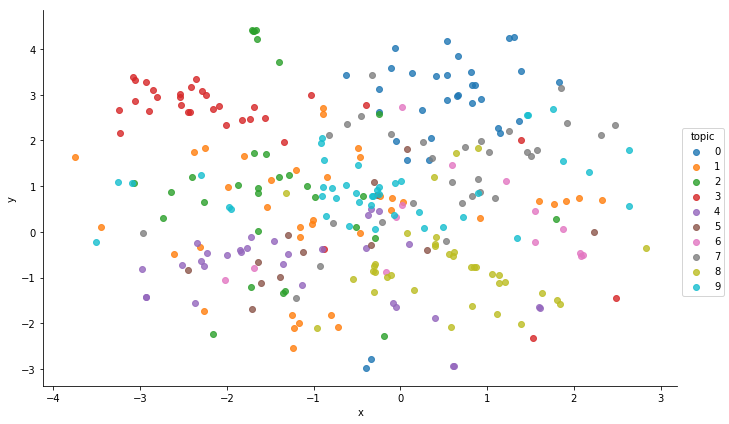

In [8]:
plot_tsne(docvecs, doc_topics)

### Compute cosine similarity from doc2vec

In [9]:
from gensim.models import KeyedVectors

def compute_similarity(docvecs):
    def compute_one(docvec):
        return (KeyedVectors.cosine_similarities(docvec, docvecs).reshape(1,-1) + 1) / 2
    
    return np.concatenate([compute_one(docvec) for docvec in docvecs])

In [10]:
distance_matrix = compute_similarity(docvecs)

### Compare intra-topic similarity vs. inter-topic similarity

In [11]:
def compute_sim_docs(distance_matrix, topic_id, doc_topics):
    'Return average similarity between pairs of documents within a topic.'
    doc_indices = [i for i in range(len(doc_topics)) if doc_topics[i] == topic_id]
    distances = [distance_matrix[i][j] for i in doc_indices for j in doc_indices]
    intra_sim = sum(distances) / len(distances)
    
    outdoc_indices = [i for i in range(len(doc_topics)) if doc_topics[i] != topic_id]
    distances = [distance_matrix[i][j] for i in doc_indices for j in outdoc_indices]
    inter_sim = sum(distances) / len(distances)
        
    return intra_sim, inter_sim

In [12]:
for i in range(10):
    print('topic', i)
    print(compute_sim_docs(distance_matrix, i, doc_topics))
    print()

topic 0
(0.68843479809584096, 0.57554197209928903)

topic 1
(0.62388135593931426, 0.59419595873430098)

topic 2
(0.65800922107374016, 0.59023393929140477)

topic 3
(0.72622405295260251, 0.56991151225433423)

topic 4
(0.69857907828629695, 0.60009987585292135)

topic 5
(0.67635990353025632, 0.60164132932337322)

topic 6
(0.67276619770088975, 0.5944763630717903)

topic 7
(0.6600170059209064, 0.59231913933180436)

topic 8
(0.70337117564531015, 0.59707798879367835)

topic 9
(0.65462357153833051, 0.60226992173646376)



There's not much difference between inter-topic similarity and intra-topic similarity?

---
Let's do the same for terms.

### Build word2vec model

In [13]:
def split_sentences(text):
    tokens = spa(text)
    return [sent.string.strip() for sent in tokens.sents]        

In [14]:
sentences = nlp.preprocess(split_sentences('. '.join(data)))
len(sentences), sentences[0]

(2748,
 ['hundred',
  'people',
  'forced',
  'vacate',
  'home',
  'southern',
  'highland',
  'new',
  'south',
  'wale',
  'strong',
  'wind',
  'today',
  'pushed',
  'huge',
  'bushfire',
  'towards',
  'town',
  'hill',
  'top'])

In [15]:
def build_word2vec_model(sentences):
    return Word2Vec(sentences, iter=100)

In [16]:
model = build_doc2vec_model(sentences).wv

In [17]:
def cos_sim(a, b):
    'Return cosine similarity between two given numpy arrays.'
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def compute_sim_terms(wv, topic_id, lda):
    'Return average similarity between pairs of terms within a topic.'
    terms = [lda.id2word[t] for t, p in lda.get_topic_terms(topic_id, topn=5)]
    return np.mean([wv.similarity(a, b) for (a, b) in combinations(terms, 2)])

In [26]:
word2vec_coherences = [compute_sim_terms(model, i, lda) for i in range(lda.num_topics)]

In [32]:
cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
umass_coherences = cm.get_coherence_per_topic()

In [36]:
def get_sorted_indices(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)

In [37]:
get_sorted_indices(word2vec_coherences), get_sorted_indices(umass_coherences)

([6, 1, 9, 8, 7, 2, 5, 4, 0, 3], [4, 6, 5, 1, 8, 9, 7, 2, 0, 3])

-1.0223927816942959

In [19]:
def compute_sim_dict(wv, terms):
    'Return the average similarity between all pairs of words in the dictionary.'
    return np.mean([wv.similarity(a, b) for (a, b) in combinations(terms, 2)])

In [20]:
compute_sim_dict(model, list(model.vocab.keys()))

0.057995222412749348

Looks promising! The average of term similarity in the entire dictionary is much smaller than that in a given topic. Let's look at t-sne projection.

In [21]:
wordvecs = np.concatenate([model[t].reshape(1, -1) for t in model.vocab])

#### Find the strongest topic for each term

In [22]:
from collections import defaultdict

def find_strongest_topics(lda, vocab):
    'Return the strongest topic associated with each term in the vocab (the dictionary of word2vec).'
    lookup = defaultdict(lambda: -1)    
    for t in lda.id2word:
        topics = lda.get_term_topics(t)
        if topics:
            lookup[lda.id2word[t]] = topics[0][0]

    return [lookup[t] for t in model.vocab]

In [23]:
term_topics = find_strongest_topics(lda, model.vocab)
len(term_topics)

772

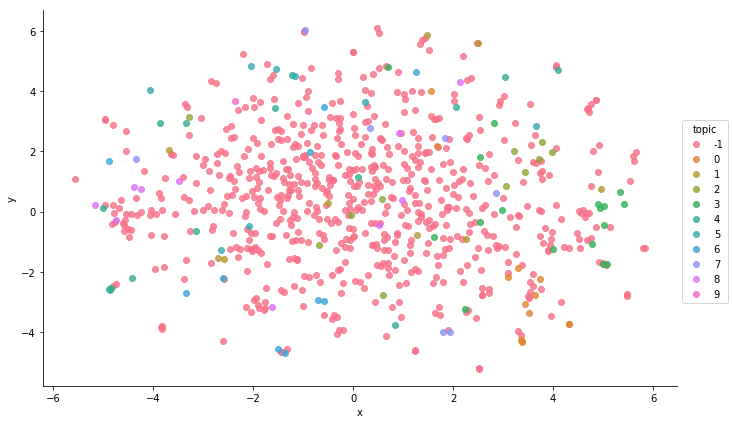

In [24]:
plot_tsne(wordvecs, term_topics)